# Initialization

In [57]:
# Устанавливается необходимая версия пакетов для воспроизводимости экспирементов
# А так же для установки всех недостающих зависимостей

'''Windows'''
!python -m venv venv
!.\venv\Scripts\activate
!pip install -r requirements.txt

'''Linux''';
#!python -m venv venv  
#!source ./venv/bin/activate  
#!pip install -r requirements.txt

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [59]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
Numpy        : 1.22.3


In [60]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [61]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

##  functions

In [62]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

##  Data

In [63]:
from pathlib import Path 

train = pd.read_pickle( Path("data", "all_auto_ru_09_09_2020.pickle_bz2"),
                compression='bz2')
test = pd.read_pickle( Path("data", "test.pickle_bz2"),
                compression='bz2')

# Первичный анализ

Есть датасет test, по которому нужно предсказать стоимость поддержанного автомобиля, при этом обучать модель для предсказаний на кагл на нём нельзя.

Для начала стоит понять, по каким данным будут делаться предсказания

## Test

### Пропуски

In [64]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,5))
sns_heatmap = sns.heatmap(
    test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Как видно, они очень плотно распределены всего по трём столбцам, что очень радует. Сразу видно, что столбец `complectation_dict` стоит выкинуть, поскольку в нем больше пропусков, чем данных. так же сразу стоит посмотреть на остальные столбцы с пропусками

#### complectation_dict

In [65]:
isna= test.complectation_dict.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.complectation_dict.dropna().iloc[0]

Заполненность данными: 0.18503142478233292


'{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'

Видно, что это словарь. Данных в этом столбце меньше 20 процентов.

Тут указан id, что может быть полезно только при объединении таблицы; имя, чем бы оно ни было; и перечисление возможных опций автомобиля. Это не несёт ценности. Этот столбец будет отфильтрован.

#### equipment_dict        

In [66]:
isna= test.equipment_dict.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.equipment_dict.dropna().iloc[0]

Заполненность данными: 0.7118145649541602


'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

Видно, что это тоже словарь, но он содержит  уже вполне себе определенную комплектацию автомобиля. Эти данные можно будет использовать для преобразования в категориальные переменные. Оданко большое количество пропусков критично. Думаю, можно сделать отдельный признак, обозначающий отсутствие данных в этом столбце. Можно будет сделать данные не бинарными, а категориальными, содержащие три признака: есть, нет, отсутствую данные

#### Владение

In [67]:
isna= test.Владение.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.Владение.dropna().iloc[0]

Заполненность данными: 0.3458167560399008


'3 года и 2 месяца'

Столбец заполнен на 35% 

Видно, что это строка, которая указывает время владения. Предположительно, последнего владельца, но это нужно проверить. 

Данных маловато, но зато можно будет сделать из них бинарный признак, указал ли водитель время использования или нет. Но скорее всего после проверки этот столбец не будет использоваться вовсе.

In [68]:
print('TRAIN','Rows =', np.shape(train)[0],'Columns =', np.shape(train)[1], sep=' ')
print('TEST ','Rows =', np.shape(test)[0],'Columns =', np.shape(test)[1], sep=' ') 

TRAIN Rows = 89378 Columns = 26
TEST  Rows = 34686 Columns = 32


Даже простое сравнение по размеру матриц TRAIN и TEST говорит о том, что они не совпадают.

Анализ типа и содержания данных в столбце позволит сделать предварительную обработку (представить данные в едином формате), а также ответить на вопрос, есть ли общие данные в несовпадающих (предположительно, по названию) столбцах TRAIN и TEST.

In [69]:
#Удаление дублирующихся строк
train_mod = train.drop_duplicates()
test_mod = test.drop_duplicates()

print('TRAIN','Rows =', np.shape(train_mod)[0],'Columns =', np.shape(train_mod)[1], sep=' ')
print('TEST ','Rows =', np.shape(test_mod)[0],'Columns =', np.shape(test_mod)[1], sep=' ') 

TRAIN Rows = 87264 Columns = 26
TEST  Rows = 34686 Columns = 32


In [70]:
#Разбираемся с препроцессингом и потерей половины строк в трейне
%store train_mod 
%store test_mod

Stored 'train_mod' (DataFrame)
Stored 'test_mod' (DataFrame)


[Preprocessing_and_thoughts](./secondary_notebooks/Preprocessing_and_thoughts.ipynb)

Сравнение размера матриц до и после удаления дубликатов показывает, что TRAIN были дублирующиеся строки, теперь их нет.

##### Определение общих и различающихся столбцов в TRAIN и TEST

In [13]:
#Общие столбцы
common_columns = set(test.columns).intersection(train.columns)

#Только в TEST
test_only_columns = set(test.columns).difference(train.columns)

#Только в TRAIN
train_only_columns = set(train.columns).difference(test.columns)

#### Вопросы для дальнейшего анализа:
1. Совпадают ли типы данных в общих столбцах?
2. Есть ли сходные по содержанию данные в столбцах с разным названием?
3. Есть ли столбцы, которые можно удалить?

##### Общие столбцы TRAIN и TEST - сравнение данных

In [14]:
#Датафрейм со сравнением типов данных
index_list = test[common_columns].dtypes.index.to_list()
test_list = test[common_columns].dtypes.values.tolist()
train_list = train[common_columns].dtypes.values.tolist()

dict_comparison = {
    'title': index_list,
    'test_type': test_list,
    'train_type': train_list
}

comparison = pd.DataFrame(dict_comparison)
comparison.sort_values('title')

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3298209608.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index_list = test[common_columns].dtypes.index.to_list()
C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3298209608.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_list = test[common_columns].dtypes.values.tolist()
C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3298209608.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_list = train[common_columns].dtypes.values.tolist()


,title,test_type,train_type
8,bodyType,object,object
5,brand,object,object
10,color,object,object
16,description,object,object
6,engineDisplacement,object,object
18,enginePower,object,float64
17,fuelType,object,object
13,mileage,int64,int64
9,modelDate,int64,float64
11,name,object,object


Как можно видеть, формат данных в части столбцов с одинаковыми названиями не совпадает. Также необходимо исследовать содержаимое ячеек.

##### Бренды в TRAIN и TEST

In [15]:
display(train_mod.brand.unique())
print('Всего в TRAIN',len(train.brand.unique()),'брендов.',sep=' ')

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

Всего в TRAIN 36 брендов.


In [16]:
display(test_mod.brand.unique())
print('Всего в TEST',len(test_mod.brand.unique()),'брендов.',sep=' ')

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

Всего в TEST 12 брендов.


Мы видим, что в TRAIN представлено в 3 раза больше брендов автомобилей. Посмотрим на их распределение в обоих датасетах.

Text(0.5, 1.0, 'TEST brands')

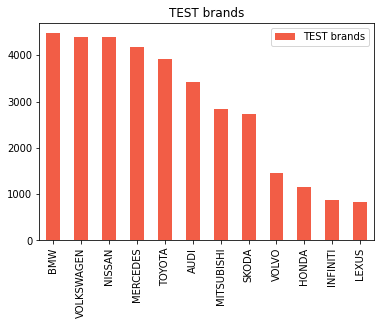

In [17]:
#Распределение брендов в TEST
test_mod['brand'].value_counts().plot(kind='bar', color = '#F25D46', label='TEST brands')
plt.legend()
plt.title('TEST brands')

Text(0.5, 1.0, 'TRAIN brands')

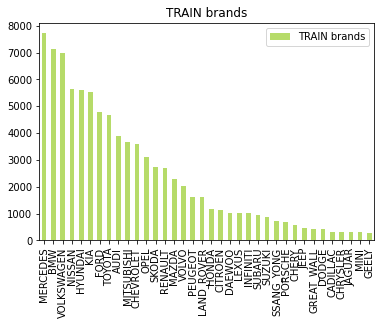

In [18]:
#Распределение брендов в TRAIN
train_mod['brand'].value_counts().plot(kind='bar', color = '#B6DB69', label='TRAIN brands')
plt.legend()
plt.title('TRAIN brands')

Мы видим, что распеределение брендов, представленных только во TEST, схоже с TRAIN. 

Поэтому для базовой модели ML отсутствующие модели можно удалить, однако для Staking и ансамблей можно попробовать объединить присутствующие и удаленные модели в классы для извлечения новых признаков.

Text(0.5, 1.0, 'MOD_TRAIN brands')

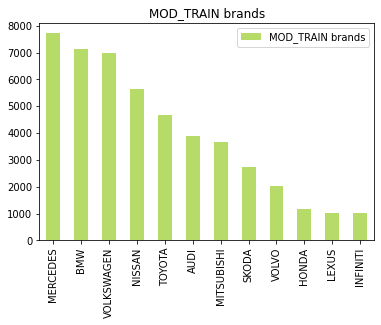

In [19]:
#Удаление отсутствующих в TEST брендов
#Список брендов из TEST
brand_list = test_mod.brand.unique().tolist()
train_mod = train_mod.loc[train.brand.isin(brand_list)]

#Распределение брендов в модифицированном TRAIN
train_mod['brand'].value_counts().plot(kind='bar', color = '#B6DB69', label='MOD_TRAIN brands')
plt.legend()
plt.title('MOD_TRAIN brands')

##### Сравнение содержание ячеек TRAIN и TEST, приведение к единому формату

In [20]:
#Датафрейм со сравнением типов данных
index_list = test[common_columns].dtypes.index.to_list()
test_list = test[common_columns].dtypes.values.tolist()
train_list = train[common_columns].dtypes.values.tolist()

dict_comparison = {
    'title': index_list,
    'test_type': test_list,
    'train_type': train_list
}

comparison = pd.DataFrame(dict_comparison)
comparison.sort_values('title')

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3298209608.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index_list = test[common_columns].dtypes.index.to_list()
C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3298209608.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_list = test[common_columns].dtypes.values.tolist()
C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3298209608.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_list = train[common_columns].dtypes.values.tolist()


,title,test_type,train_type
8,bodyType,object,object
5,brand,object,object
10,color,object,object
16,description,object,object
6,engineDisplacement,object,object
18,enginePower,object,float64
17,fuelType,object,object
13,mileage,int64,int64
9,modelDate,int64,float64
11,name,object,object


In [21]:
#Функция для просмотра и сравнения типов данных в столбцах
def type_comparison(column):
    print('TEST')
    display(test_mod[column].sample(5))
    print('TRAIN')
    display(train_mod[column].sample(5))  

In [22]:
#bodyType
column = 'bodyType'
type_comparison(column)

TEST


28117              седан
29892              седан
13157              седан
17941              седан
1046     универсал 5 дв.
Name: bodyType, dtype: object

TRAIN


67059    Пикап Одинарная кабина 79
45966                   Компактвэн
45723            Внедорожник 5 дв.
3368             Внедорожник 5 дв.
8883             Внедорожник 5 дв.
Name: bodyType, dtype: object

Необходимо привести данные к единому формату и убрать из значениё кол-во двер


In [23]:
#color
column = 'color'
type_comparison(column)

TEST


12190         чёрный
10703     коричневый
29804    серебристый
29449         чёрный
17699         чёрный
Name: color, dtype: object

TRAIN


60751    EE1D19
82303    FAFBFB
49926    040001
31927    C49648
30947    040001
Name: color, dtype: object

In [24]:
#description
column = 'description'
type_comparison(column)

TEST


12452    Доброго времени суток. Продаю свой автомобиль....
29602    Редкий экземпляр BMW e39 Turing с мотором 4.4 ...
33463    Продаю автомобиль жены, авто в отличном состоя...
20051    Машина приобреталась в декабре 18 года.\nКомпл...
22883    В прекрасном состоянии, вложений не требует. В...
Name: description, dtype: object

TRAIN


2689                            Авто в отличном состоянии 
51214    Авто в отличном состоянии, не требует вложений...
78230    «Inchcape Certified-  Первый международный офи...
75923    Пневмоподвеска, вибаста, зимняя резина,защита ...
50131    МАШИНА В ИВАНТЕЕВКЕ!!!\nВыкупы, карпрайсы и пр...
Name: description, dtype: object

In [25]:
#engineDisplacement
column = 'engineDisplacement'
type_comparison(column)

TEST


18756    1.6 LTR
28822    3.2 LTR
23474    1.4 LTR
27179    2.0 LTR
18350    3.5 LTR
Name: engineDisplacement, dtype: object

TRAIN


65947     2.0
7062     525i
66824    4.5d
50377     2.4
75315     2.0
Name: engineDisplacement, dtype: object

Необходимо привести данные к единому формату

In [26]:
#Преобразование
def GetEngineDisplacement(x):
    row = str(x)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

train_mod['engineDisplacement'] = train_mod['engineDisplacement'].map(GetEngineDisplacement)
test_mod['engineDisplacement'] = test_mod['engineDisplacement'].map(GetEngineDisplacement)

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\1747633296.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod['engineDisplacement'] = train_mod['engineDisplacement'].map(GetEngineDisplacement)


In [27]:
#engineDisplacement
column = 'engineDisplacement'
type_comparison(column)

TEST


3242     2.0
32449    1.8
24974    1.8
12579    1.6
13900    2.0
Name: engineDisplacement, dtype: float64

TRAIN


75919    3.0
8563     NaN
39242    NaN
2314     3.1
61635    1.6
Name: engineDisplacement, dtype: float64

После преобразования в столбцах появились пропуски

In [28]:
test_mod[test_mod['engineDisplacement'].isna()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
5241,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/e_tron/110...,белый,NaN,Audi e-tron Prestige quattro от Moscow Tesla C...,NaN,408 N12,"{""asr"":true,""esp"":true,""usb"":true,""e-adjustmen...",электро,...,ALLROAD_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 год и 3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен
7992,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11010431...,синий,NaN,"Атомобиль из Германии,без пробега по РФ.\nНа г...",NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8252,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012780...,серый,NaN,"Пробег 54000 км, запас хода на зарядке 130 км+...",NaN,170 N12,"{""park-assist-f"":true,""park-assist-r"":true}",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8350,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11002716...,белый,"{""id"":""21624597"",""name"":""i3 120 Ah"",""available...","Автомобиль в наличии Москве , с ПТС , производ...",NaN,170 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8684,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11011745...,чёрный,NaN,BMW I 3 REX\nфевраль 2017 года выпуска.\nПриоб...,NaN,170 N12,"{""cruise-control"":true,""glonass"":true,""navigat...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8722,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11000973...,голубой,NaN,\nПрибыло из Америки в августе 2020 года. Полн...,NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8917,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11008715...,бежевый,NaN,-Состояние нового автомобиля .\n-Carfax вся ис...,NaN,170 N12,"{""glonass"":true,""roof-rails"":true}",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10817,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012664...,серый,NaN,Продаю BMW I3 +REX .\n\nПолноценный электромоб...,NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10936,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/10996733...,чёрный,NaN,Автомобиль BMW i3 (полностью электрический )за...,NaN,170 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
11043,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/10993761...,серый,NaN,Состояние нового автомобиля . \nФото ИМЕННО ЭТ...,NaN,170 N12,"{""glonass"":true,""airbag-driver"":true,""aux"":tru...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,8 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен


In [29]:
train_mod[train_mod['engineDisplacement'].isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
45,Седан,AUDI,040001,бензин,1990.0,S4 2.2 AT (230 л.с.) 4WD,4.0,1992,SEDAN AUTOMATIC S4,AUTOMATIC,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,220000.0,2020-07-09T06:57:21Z,NaN,100
345,Седан,AUDI,040001,бензин,2012.0,ultra 1.4 AMT (150 л.с.),4.0,2016,SEDAN ROBOT ultra,ROBOT,...,LEFT,NaN,2.0,ORIGINAL,True,NaN,1254090.0,2020-09-05T16:01:05Z,NaN,A3
383,Седан,AUDI,FAFBFB,бензин,2012.0,ultra 1.4 AMT (150 л.с.),4.0,2015,SEDAN ROBOT ultra,ROBOT,...,LEFT,NaN,1.0,ORIGINAL,True,NaN,870000.0,2020-07-28T11:55:47Z,NaN,A3
658,Универсал 5 дв.,AUDI,040001,дизель,2004.0,8V 2.0d MT (140 л.с.),5.0,2005,WAGON_5_DOORS MECHANICAL 8V,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2020, 'month': 2}",380000.0,2020-09-08T19:06:10Z,NaN,A4
671,Универсал 5 дв.,AUDI,040001,дизель,2004.0,8V 2.0d CVT (140 л.с.),5.0,2007,WAGON_5_DOORS VARIATOR 8V,VARIATOR,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,395000.0,2020-07-26T20:05:31Z,NaN,A4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88647,Седан,MERCEDES,FAFBFB,бензин,1984.0,200 2.0 MT (122 л.с.),4.0,1988,SEDAN MECHANICAL 200,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,"{'year': 2020, 'month': 7}",130000.0,2020-08-12T17:23:57Z,NaN,W124
88648,Седан,MERCEDES,040001,бензин,1984.0,230 2.3 AT (132 л.с.),4.0,1988,SEDAN AUTOMATIC 230,AUTOMATIC,...,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2016, 'month': 9}",110000.0,2019-12-20T09:16:45Z,NaN,W124
88658,Пикап Двойная кабина,MERCEDES,97948F,дизель,2017.0,350 d 3.0d AT (258 л.с.) 4WD,4.0,2018,PICKUP_TWO AUTOMATIC 350,AUTOMATIC,...,LEFT,NaN,1.0,ORIGINAL,True,"{'year': 2019, 'month': 12}",4000000.0,2020-03-03T14:56:44Z,NaN,X_KLASSE
88659,Пикап Двойная кабина,MERCEDES,97948F,дизель,2017.0,250 d 2.3d AT (190 л.с.) 4WD,4.0,2018,PICKUP_TWO AUTOMATIC 250,AUTOMATIC,...,LEFT,NaN,1.0,ORIGINAL,True,NaN,3150000.0,2020-08-05T07:36:53Z,NaN,X_KLASSE


Возможно, эти пропуски мы сможем заполнить, взяв информацию из столбца name

In [30]:
test_mod[test_mod['engineDisplacement'].isna()]['name']

5241     55 Electro AT (301 кВт) 4WD
7992            Electro AT (126 кВт)
8252            Electro AT (126 кВт)
8350            Electro AT (126 кВт)
8684       94Ah Electro AT (126 кВт)
8722            Electro AT (126 кВт)
8917       94Ah Electro AT (126 кВт)
10817           Electro AT (126 кВт)
10936           Electro AT (126 кВт)
11043      94Ah Electro AT (126 кВт)
11302            Electro AT (81 кВт)
11682           Electro AT (111 кВт)
11714           Electro AT (111 кВт)
11719            Electro AT (81 кВт)
11754            Electro AT (81 кВт)
11878            Electro AT (81 кВт)
11974            Electro AT (81 кВт)
12072            Electro AT (81 кВт)
12085            Electro AT (81 кВт)
12100      30kWh Electro AT (81 кВт)
12250            Electro AT (81 кВт)
12287            Electro AT (81 кВт)
12334            Electro AT (81 кВт)
12466      30kWh Electro AT (81 кВт)
12481            Electro AT (81 кВт)
12558            Electro AT (81 кВт)
12582      30kWh Electro AT (81 кВт)
1

Очевидно что в TEST объём двигателя отсутствует исключительно у электромобилей. Что вполне логично. Стоит заполнить из нолями.

In [31]:
test_mod['engineDisplacement'].fillna(0, inplace = True)

In [32]:
train_mod[train_mod['engineDisplacement'].isna()]['name']

45           S4 2.2 AT (230 л.с.) 4WD
345          ultra 1.4 AMT (150 л.с.)
383          ultra 1.4 AMT (150 л.с.)
658             8V 2.0d MT (140 л.с.)
671            8V 2.0d CVT (140 л.с.)
                     ...             
88647           200 2.0 MT (122 л.с.)
88648           230 2.3 AT (132 л.с.)
88658    350 d 3.0d AT (258 л.с.) 4WD
88659    250 d 2.3d AT (190 л.с.) 4WD
88660    350 d 3.0d AT (258 л.с.) 4WD
Name: name, Length: 17094, dtype: object

В TRAIN ситуация совсем иная. С этим ещё предстоит разобраться.

In [33]:
#enginePower
column = 'enginePower'
type_comparison(column)

TEST


32585    144 N12
28850    109 N12
18659    113 N12
25237    240 N12
1474      58 N12
Name: enginePower, dtype: object

TRAIN


82013    204.0
1053     225.0
49852    185.0
81047    156.0
44553    146.0
Name: enginePower, dtype: float64

Здесь также требуется приведение к единому формату

In [34]:
#Преобразование
train_mod.enginePower = train_mod.enginePower.convert_dtypes(int)
test_mod["enginePower"] = test_mod["enginePower"].apply(lambda x : (int)(x.split(' ')[0]))

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3085074308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod.enginePower = train_mod.enginePower.convert_dtypes(int)


In [35]:
#enginePower
column = 'enginePower'
type_comparison(column)

TEST


24063    140
24800    204
24993    130
17207    306
9862     136
Name: enginePower, dtype: int64

TRAIN


61441    110
71374    180
68864    199
88503    190
62692    152
Name: enginePower, dtype: Int64

Проверим не образовались ли пропуски в этом столбце

In [36]:
test_mod[test_mod['enginePower'].isna()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня


In [37]:
train_mod[train_mod['enginePower'].isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
24624,NaN,HONDA,CACECB,универсал,NaN,NaN,NaN,1989,NaN,NaN,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,120000.0,2020-04-10T16:07:57Z,NaN,CIVIC


Образовался один пропуск. Строка с этим пропуском в целом содержит мало данным и должна быть удалена

In [38]:
train_mod.drop(24624, inplace = True)

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\114055190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod.drop(24624, inplace = True)


In [39]:
#fuelType
column = 'fuelType'
type_comparison(column)

TEST


20658    бензин
15733    дизель
19609    бензин
29408    бензин
16691    бензин
Name: fuelType, dtype: object

TRAIN


50976    бензин
31629    бензин
77066    бензин
39190    гибрид
69325    бензин
Name: fuelType, dtype: object

In [40]:
train_mod.fuelType.unique() 

array(['бензин', 'дизель', 'электро', 'гибрид', 'газ'], dtype=object)

In [41]:
test_mod.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [42]:
#mileage
column = 'mileage'
type_comparison(column)

TEST


21148    153816
21747    114000
4550     258000
24214    180000
27034     88612
Name: mileage, dtype: int64

TRAIN


51730      7000
73487     60000
47651    185167
83367    300000
72665    340000
Name: mileage, dtype: int64

In [43]:
#modelDate
column = 'modelDate'
type_comparison(column) # model year на самом деле

TEST


32686    2014
12935    2014
18867    2005
25566    2014
2485     2010
Name: modelDate, dtype: int64

TRAIN


4409     2019.0
2163     1994.0
70774    2014.0
87577    2013.0
60250    2017.0
Name: modelDate, dtype: float64

In [44]:
#Преобразование
train_mod.modelDate = train_mod.modelDate.convert_dtypes(int) #astype('int')

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\2954420463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod.modelDate = train_mod.modelDate.convert_dtypes(int) #astype('int')


In [45]:
column = 'modelDate'
type_comparison(column)

TEST


18461    2016
1286     2013
32069    2001
32469    2008
9405     2013
Name: modelDate, dtype: int64

TRAIN


77426    2018
84162    2009
1077     1999
74809    2011
81000    2018
Name: modelDate, dtype: Int64

In [46]:
#name
column = 'name'
type_comparison(column)

TEST


26081             2.0 AT (150 л.с.)
33128    FX35 3.5 AT (280 л.с.) 4WD
20849             2.5 AT (181 л.с.)
8428         318i 2.0 AT (143 л.с.)
27207            1.8 CVT (140 л.с.)
Name: name, dtype: object

TRAIN


71958              2.0 AMT (190 л.с.)
75574           3.2 AT (241 л.с.) 4WD
156                  1.8 MT (90 л.с.)
83923    63 AMG 5.5 AT (571 л.с.) 4WD
7469           528i 2.8 MT (193 л.с.)
Name: name, dtype: object

В этой колонке есть информация об объёме двигателя. Её можно использовать для заполнения пропусков в столбце engineDisplacement.

In [47]:
#numberOfDoors
column = 'numberOfDoors'
type_comparison(column)

TEST


28949    4
20997    4
9012     4
28421    5
22967    4
Name: numberOfDoors, dtype: int64

TRAIN


85900    5.0
76767    4.0
46548    4.0
46464    4.0
6192     4.0
Name: numberOfDoors, dtype: float64

In [48]:
#Преобразование
train_mod.numberOfDoors = train_mod.numberOfDoors.convert_dtypes(int)

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3213111795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod.numberOfDoors = train_mod.numberOfDoors.convert_dtypes(int)


In [49]:
#productionDate # дата производства, есть ещё дата модели
column = 'productionDate'
type_comparison(column)

TEST


33555    2009
6227     2018
6319     2009
5947     1997
2112     2008
Name: productionDate, dtype: int64

TRAIN


75837    2008
88112    2013
31608    2019
84624    2020
10192    2016
Name: productionDate, dtype: int64

In [50]:
#vehicleConfiguration
column = 'vehicleConfiguration'
type_comparison(column)

TEST


19765              SEDAN AUTOMATIC 1.8
24746    ALLROAD_5_DOORS AUTOMATIC 3.0
22018              SEDAN AUTOMATIC 2.5
28943             SEDAN MECHANICAL 1.6
23085              SEDAN AUTOMATIC 3.5
Name: vehicleConfiguration, dtype: object

TRAIN


68038     WAGON_5_DOORS AUTOMATIC 1.8
68519    ALLROAD_5_DOORS VARIATOR 2.0
72054            SEDAN MECHANICAL 1.8
51177    ALLROAD_5_DOORS VARIATOR 2.5
81228             SEDAN AUTOMATIC 300
Name: vehicleConfiguration, dtype: object

Этот столбец тоже можно использовать для заполнения пропусков в столбце engineDisplacement.

In [51]:
#vehicleTransmission
column = 'vehicleTransmission'
type_comparison(column)

TEST


22559    автоматическая
12939          вариатор
2053     автоматическая
8539     автоматическая
1620     автоматическая
Name: vehicleTransmission, dtype: object

TRAIN


70689        ROBOT
42317    AUTOMATIC
1781         ROBOT
73955    AUTOMATIC
85343    AUTOMATIC
Name: vehicleTransmission, dtype: object

In [52]:
#Преобразование
train_mod.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object)

In [53]:
test_mod.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [54]:
test_mod = test_mod.replace({'vehicleTransmission':
                            {'автоматическая': 'AUTOMATIC',
                            'вариатор': 'VARIATOR',
                            'механическая': 'MECHANICAL',
                            'роботизированная': 'ROBOT'}})

In [55]:
#Владельцы
column = 'Владельцы'
type_comparison(column)

TEST


32558     1 владелец
11647     1 владелец
3822     3 или более
28698     1 владелец
16952     1 владелец
Name: Владельцы, dtype: object

TRAIN


48097    3.0
82720    3.0
60046    3.0
5875     1.0
10395    NaN
Name: Владельцы, dtype: float64

In [56]:
test_mod.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [57]:
#Преобразование
train_mod.Владельцы = train_mod.Владельцы.convert_dtypes(int)

test_mod = test_mod.replace({'Владельцы':
                            {'1\xa0владелец': 1,
                            '2\xa0владельца': 2,
                            '3 или более': 3}})

C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\3880624668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mod.Владельцы = train_mod.Владельцы.convert_dtypes(int)


In [58]:
#Владение
column = 'Владение' # перевести в дни, можно выкинуть
type_comparison(column)

TEST


2900                    NaN
4337     3 года и 6 месяцев
14155                   NaN
10957                   NaN
27958    2 года и 7 месяцев
Name: Владение, dtype: object

TRAIN


74647    {'year': 2014, 'month': 6}
65026    {'year': 2020, 'month': 1}
65585                           NaN
38631                           NaN
70196    {'year': 2014, 'month': 7}
Name: Владение, dtype: object

In [59]:
#Посчитаем % пропусков
col = 'Владение'

pct_missing_1 = np.mean(test[col].isnull()) 
print('TEST')
print('{} - {}%'.format(col, round(pct_missing_1*100)))
pct_missing_2 = np.mean(train_mod[col].isnull()) 
print('TRAIN')
print('{} - {}%'.format(col, round(pct_missing_2*100)))

TEST
Владение - 65%
TRAIN
Владение - 69%


Большой процент пропусков в TRAIN и TEST (около 70%), столбец можно удалить.

In [60]:
#Привод
column = 'Привод'
type_comparison(column)

TEST


7615       полный
24776    передний
21069    передний
1538     передний
6286     передний
Name: Привод, dtype: object

TRAIN


9858       полный
43322      полный
76592    передний
87215      полный
6416       задний
Name: Привод, dtype: object

In [61]:
#ПТС
column = 'ПТС'
type_comparison(column)

TEST


10346    Оригинал
22986    Оригинал
24268    Оригинал
21538    Оригинал
1794     Оригинал
Name: ПТС, dtype: object

TRAIN


48984    ORIGINAL
65728    ORIGINAL
1002     ORIGINAL
72313    ORIGINAL
82960    ORIGINAL
Name: ПТС, dtype: object

In [62]:
#Преобразование
test_mod = test_mod.replace({'ПТС':
                            {'Оригинал': 'ORIGINAL',
                            'Дубликат': 'DUPLICATE'}})

In [63]:
#Руль
column = 'Руль'
type_comparison(column)

TEST


29036    Левый
20951    Левый
5072     Левый
4559     Левый
5313     Левый
Name: Руль, dtype: object

TRAIN


50242    LEFT
7036     LEFT
6257     LEFT
70521    LEFT
86618    LEFT
Name: Руль, dtype: object

In [64]:
#Преобразование
test_mod = test_mod.replace({'Руль':
                            {'Левый': 'LEFT',
                            'Правый': 'RIGHT'}})

In [65]:
#Состояние # выкинуть
column = 'Состояние'
type_comparison(column)

TEST


13894    Не требует ремонта
6343     Не требует ремонта
31826    Не требует ремонта
22980    Не требует ремонта
23148    Не требует ремонта
Name: Состояние, dtype: object

TRAIN


85204   NaN
77488   NaN
9620    NaN
82453   NaN
81579   NaN
Name: Состояние, dtype: float64

In [66]:
test_mod.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

In [67]:
train_mod.Состояние.unique()

array([nan])

В TEST только одно значение, в TRAIN - пустой столбец. СОСТОЯНИЕ можно удалить.

In [68]:
#Таможня
column = 'Таможня'
type_comparison(column)

TEST


25714    Растаможен
29187    Растаможен
21744    Растаможен
21411    Растаможен
30423    Растаможен
Name: Таможня, dtype: object

TRAIN


46572    True
5380     True
38614    True
3501     True
43800    True
Name: Таможня, dtype: bool

In [69]:
test_mod.Таможня.unique()

array(['Растаможен'], dtype=object)

In [70]:
train_mod.Таможня.unique()

array([ True])

В TRAIN и TEST во всех строках одинаковое значение, столбец ТАМОЖНЯ можно удалить.

### Столбцы ТОЛЬКО TEST

In [71]:
test_mod[test_only_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   vendor              34686 non-null  object
 1   sell_id             34686 non-null  int64 
 2   equipment_dict      24690 non-null  object
 3   car_url             34686 non-null  object
 4   image               34686 non-null  object
 5   complectation_dict  6418 non-null   object
 6   parsing_unixtime    34686 non-null  int64 
 7   model_name          34686 non-null  object
 8   priceCurrency       34686 non-null  object
 9   super_gen           34686 non-null  object
 10  model_info          34686 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.2+ MB


C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\1526034085.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_mod[test_only_columns].info()


In [72]:
#equipment_dict
#Процент пропусков
col = 'equipment_dict'
missing = np.mean(test_mod[col].isnull()) 
print('{} - {}%'.format(col, round(missing*100)))

equipment_dict - 29%


In [73]:
test_mod.equipment_dict.sample(5)

19418    {"airbag-rear-side":true,"asr":true,"airbag-dr...
11232    {"alloy-wheel-disks":true,"ptf":true,"airbag-d...
20045    {"cruise-control":true,"esp":true,"usb":true,"...
2636     {"asr":true,"esp":true,"airbag-driver":true,"l...
26435    {"cruise-control":true,"asr":true,"tinted-glas...
Name: equipment_dict, dtype: object

In [74]:
test_mod.equipment_dict[938] # Ментор сказал выкинуть, кек

'{"engine-proof":true,"tinted-glass":true,"esp":true,"airbag-driver":true,"aux":true,"isofix":true,"usb":true,"electro-window-front":true,"hcc":true,"audiopreparation":true,"heated-wash-system":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"seat-transformation":true,"wheel-power":true,"lock":true,"fabric-seats":true,"electro-mirrors":true,"steel-wheels":true,"rain-sensor":true,"airbag-side":true,"mirrors-heat":true,"driver-seat-updown":true,"condition":true,"led-lights":true,"abs":true,"front-seats-heat":true,"wheel-configuration1":true,"immo":true,"12v-socket":true,"15-inch-wheels":true}'

Данные содержат описание комплектации, могут служить для извлечения дополнительных признаков.

In [75]:
#super_gen можно заменить пропуски
test_mod.super_gen.sample(5)

14206    {"id":"7024211","displacement":2488,"engine_ty...
28605    {"id":"20701945","displacement":3200,"engine_t...
20781    {"id":"2410246","displacement":4461,"engine_ty...
3376     {"id":"6469003","displacement":4134,"engine_ty...
17152    {"id":"20071230","name":"500","nameplate":"500...
Name: super_gen, dtype: object

In [76]:
test_mod.super_gen[938]

'{"id":"20105521","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":12.2,"clearance_min":155,"fuel_rate":6.7}'

Данные частично дублируются с vehicleTransmission и engineDisplacement, однако, пропусков в тех столбцах нет - столбец super_gen следует удалить

In [77]:
#model_info # Выкинуть
test_mod.model_info.sample(5)

1174     {"code":"SUPERB","name":"Superb","ru_name":"Су...
22314    {"code":"COROLLA_LEVIN","name":"Corolla Levin"...
18606    {"code":"C_KLASSE","name":"C-Класс","ru_name":...
31026    {"code":"OCTAVIA","name":"Octavia","ru_name":"...
12198    {"code":"SENTRA","name":"Sentra","ru_name":"Се...
Name: model_info, dtype: object

In [78]:
test_mod.model_info[938]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [79]:
test_mod.model_info[4469]

'{"code":"80","name":"80","ru_name":"80","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [80]:
test_mod.model_info[3495]

'{"code":"A5","name":"A5","ru_name":"А5","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

Столбец MODEL_INFO дублирует информацию BRAND, можно удалить.

In [81]:
#vendor
test_mod.vendor.sample(5)

2086     EUROPEAN
17991    EUROPEAN
16587    EUROPEAN
16792    EUROPEAN
20849    JAPANESE
Name: vendor, dtype: object

In [82]:
test_mod.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [83]:
test_mod[test_mod['vendor'] == 'EUROPEAN']['brand'].unique()

array(['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN'],
      dtype=object)

In [84]:
test_mod[test_mod['vendor'] == 'JAPANESE']['brand'].unique()

array(['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI'],
      dtype=object)

Европейским брендам соответствует европейский вендор, японским - соответственный. Возможно, этот столбец является ключом для создания дополнительного признака - страна или концерн, производящий определенный бренд.

In [85]:
#sell_id
test_mod.sell_id.sample(5)

9820     1094656346
18565    1077814084
23825    1099364686
7332     1100362122
28719    1098045976
Name: sell_id, dtype: int64

SELL_ID - неинформативный столбец, необходимо удалить.

In [86]:
#complectation_dict
#Процент пропусков
col = 'complectation_dict'
missing = np.mean(test_mod[col].isnull()) 
print('{} - {}%'.format(col, round(missing*100)))

complectation_dict - 81%


In [87]:
test_mod.complectation_dict.head(20)

0                                                   NaN
1                                                   NaN
2     {"id":"20026336","name":"Ambition","available_...
3     {"id":"20803582","name":"Ambition","available_...
4                                                   NaN
5     {"id":"5011515","name":"RS","available_options...
6     {"id":"20069264","name":"Elegance","available_...
7                                                   NaN
8                                                   NaN
9                                                   NaN
10                                                  NaN
11                                                  NaN
12                                                  NaN
13                                                  NaN
14                                                  NaN
15                                                  NaN
16    {"id":"20913628","name":"Style","available_opt...
17                                              

В столбце COMPLECTATION_DICT большой процент пропусков, его нужно удалить.

In [88]:
#parsing_unixtime
test_mod.parsing_unixtime.sample(5)

20268    1603291108
28730    1603267565
27069    1603261320
6451     1603236099
310      1603227474
Name: parsing_unixtime, dtype: int64

Данный столбец бесполезен и его следует удалить.

In [89]:
#model_name
test_mod.model_name.sample(5)

11830               X_TRAIL
15766              M_KLASSE
15084                    FX
24216              MULTIVAN
19976    LAND_CRUISER_PRADO
Name: model_name, dtype: object

MODEL_NAME: Обозначение модели конкретного бренда, нужно уточнить корреспондирующую информацию в TRAIN.

In [90]:
#priceCurrency 
test_mod.priceCurrency.sample(5)

7786     RUB
34160    RUB
9521     RUB
26558    RUB
27637    RUB
Name: priceCurrency, dtype: object

In [91]:
test_mod.priceCurrency.unique()

array(['RUB'], dtype=object)

Во всех строках одно значение, столбец priceCurrency можно удалить.

In [92]:
#image
test_mod.image.sample(5)

31096    https://avatars.mds.yandex.net/get-autoru-vos/...
20699    https://avatars.mds.yandex.net/get-autoru-vos/...
10953    https://autoru.naydex.net/ys1kR7800/fbd964zfcB...
32096    https://autoru.naydex.net/1xsMU7627/eea2057RFg...
26477    https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...
Name: image, dtype: object

Ссылки на недоступные фото товаров, не работают, столбец IMAGE можно удалить.

In [93]:
#car_url
test_mod.car_url.sample(5)

19199    https://auto.ru/cars/used/sale/toyota/verso/11...
9874     https://auto.ru/cars/used/sale/bmw/5er/1101247...
7        https://auto.ru/cars/used/sale/skoda/octavia/1...
18811    https://auto.ru/cars/used/sale/mercedes/s_klas...
5684     https://auto.ru/cars/used/sale/honda/accord/10...
Name: car_url, dtype: object

Ссылки на недоступные объявления, не работают, столбец CAR_URL можно удалить.

### Столбцы ТОЛЬКО TRAIN

In [94]:
train_mod[train_only_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47661 entries, 0 to 88660
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         47453 non-null  float64
 1   model         47661 non-null  object 
 2   Комплектация  47661 non-null  object 
 3   hidden        0 non-null      float64
 4   start_date    47661 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.2+ MB


C:\Users\zetet\AppData\Local\Temp\ipykernel_15740\2215295339.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_mod[train_only_columns].info()


#hidden
Столбец со всеми нулевыми значениями, можно удалить.

In [95]:
#model
train_mod.model.sample(5)

11094                    X6
38552                    GS
73645                  POLO
67558    LAND_CRUISER_PRADO
48351               PRIMERA
Name: model, dtype: object

Столбец MODEL из TRAIN соответствует столбцу MODEL_NAME из TEST, необходимо дать единое название.

In [96]:
train_mod = train_mod.rename(columns = {'model': 'model_name'})

In [97]:
#Сравним формат и содержание в TRAIN и TEST
#model_name
column = 'model_name'
type_comparison(column)

TEST


4422           A3
17690    E_KLASSE
16572    E_KLASSE
30972        POLO
24338      TIGUAN
Name: model_name, dtype: object

TRAIN


4233        1ER
73091      POLO
72028    PASSAT
9328         X3
1320         A5
Name: model_name, dtype: object

In [98]:
#Комплектация
train_mod.Комплектация.sample(5)

2589     {'id': '0'}
67405    {'id': '0'}
73142    {'id': '0'}
84279    {'id': '0'}
82580    {'id': '0'}
Name: Комплектация, dtype: object

In [99]:
train_mod.Комплектация[68967]

"{'id': '21678548', 'name': 'Комфорт', 'available_options': ['cruise-control', 'multi-wheel', 'heated-wash-system', 'airbag-passenger', 'roof-rails', 'bas', 'lock', 'electro-mirrors', 'mirrors-heat', 'glonass', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'fabric-seats', 'airbag-side', 'electro-trunk', 'abs', 'wheel-leather', 'climate-control-2', 'auto-mirrors', 'asr', 'tinted-glass', 'esp', 'usb', 'audiopreparation', 'front-centre-armrest', 'rear-camera', 'electro-window-back', '18-inch-wheels', 'reduce-spare-wheel', 'body-mouldings', 'driver-seat-updown', 'wheel-heat', 'led-lights', 'park-assist-r', 'knee-airbag', 'airbag-driver', 'isofix', 'aux', 'drive-mode-sys', 'electro-window-front', 'light-sensor', 'hcc', 'airbag-curtain', 'keyless-entry', 'alarm', 'leather-gear-stick', 'start-button', 'ptf', 'rain-sensor', 'tyre-pressure', 'front-seats-heat', 'bluetooth', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'windscreen-hea

In [100]:
train_mod.Комплектация[24653]

"{'id': '0'}"

По содержанию данные частично совпадают с COMPLECTATION_DICT из TEST, все строки непустые, но при значении {'id': '0'} содержания фактически нет.


In [101]:
#Процент пропусков в Комплектации
missing = len(train_mod[train_mod['Комплектация'] == "{'id': '0'}"]['Комплектация'])
total_missing = (missing/len(train_mod)*100)
print(round(total_missing),'%')

63 %


В TRAIN в КОМПЛЕКТАЦИИ отсутствует более 60% данных. По этой причине столбец КОМПЛЕКТАЦИЯ можно удалить.

In [102]:
#start_date
train_mod.start_date.sample(5)

1630     2020-08-24T16:41:56Z
74846    2020-07-28T09:38:14Z
76030    2019-10-21T16:15:30Z
31573    2019-12-05T19:59:45Z
69589    2020-02-01T07:05:14Z
Name: start_date, dtype: object

In [103]:
# Делюсь датой с другими ноутбуками
%store train_mod 
%store test_mod

# `%store -r train_mod` создаст переменную тренеровочного датасета в любом ноутбуке

Stored 'train_mod' (DataFrame)
Stored 'test_mod' (DataFrame)


# Модели


Были опробованны модели:
- [Logistic regression](./secondary_notebooks/linear_regression.ipynb) 
- Desicion tree
- DBSCAN
- ...

In [104]:
'''Если нажать - через три минуты покажется результат "лучшей модели"   '''

from IPython.display import display
from ipywidgets import Button 

# Создаем кнопку с нужными параметрами
button1 = Button(description="Я линейная!", 
                        button_style='success'  )

def on_button_clicked(b): # Описываем обработчик события
    %run ./secondary_notebooks/linear_regression.ipynb
button1.on_click(on_button_clicked) # Назначаем этот обработчик на событие "on_click"

display(button1) # Отображаем кнопку 

Button(button_style='success', description='Я линейная!', style=ButtonStyle())